In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer
from math import sqrt

## Images reading&resizing

In [3]:
img_l = np.asanyarray(Image.open("im2.png").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)
img_r = np.asanyarray(Image.open("im6.png").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)

In [4]:
img_l.shape

(300, 400, 3)

In [5]:
img_r.shape

(300, 400, 3)

## Loss functions definition

In [6]:
def g_loss_l1(a, b, par=0):
    return abs(a) + abs(b)

def g_loss_l2(a, b, par=0):
    return sqrt(abs(a)**2 + abs(b)**2)

def g_loss_min_l1(a, b, par):
    return min(par, abs(a) + abs(b))

def g_loss_min_l2(a, b, par):
    return min(par, sqrt(abs(a)**2 + abs(b)**2))

In [7]:
def f_loss_l1(a):
    return np.sum(np.abs(a), axis=-1)

def f_loss_l2(a):
    return np.sqrt(np.sum(a**2, axis=-1))

## Params definition

In [8]:
kg_max=45
kv_max=14

alpha=40
g_loss = [g_loss_l1, g_loss_l2, g_loss_min_l1, g_loss_min_l2][3]
f_loss = [f_loss_l1, f_loss_l2][1]
b = 20

## Precomputing node2node losses

In [9]:
kv_half = kv_max//2

height = img_r.shape[0]
length = img_r.shape[1]

g = np.zeros((kg_max*kv_max, kg_max*kv_max), dtype=np.float32)
if g_loss == "l2":
    g_loss_fun
for k1 in range(kg_max*kv_max):
    for k2 in range(kg_max*kv_max):
        kg1 = k1 % kg_max
        kv1 = k1 // kg_max
        kg2 = k2 % kg_max
        kv2 = k2 // kg_max
        g[k1,k2] = g_loss(kg1 - kg2,kv1 - kv2, b)
g = alpha*g

In [10]:
kg1

44

In [11]:
kv1

13

## Minimal path finding and recording

In [12]:
start = timer()
img_shift = np.ones((height, length))

for i in range(img_shift.shape[0]):
    #start = timer()
    f = np.inf*np.ones((length, kg_max*kv_max), dtype=np.float32)
    for k in range(1, kg_max*kv_max):
        kg1 = k % kg_max
        kv1 = k // kg_max
        if kv1 >= kv_half and i + kv1 - kv_half < height:
            f[:length-kg1, k] = f_loss(img_r[i,:length-kg1] - img_l[i+kv1-kv_half,kg1:])
        elif kv1 < kv_half and i-(kv_half - kv1) >= 0:
            f[:length-kg1, k] = f_loss(img_r[i,:length-kg1] - img_l[i-(kv_half - kv1),kg1:])

    #end = timer()
    #print('\n\nconstruct graph:',timedelta(seconds=end-start))            
    #start = timer()

    pass_to_prev = np.zeros(f.shape, dtype=np.int)
    for p in range(1, length):
        ta = f[p-1, :] + g
        ind = np.argmin(ta, axis=1)
        f[p, :] += np.min(ta, axis=1)
        pass_to_prev[p, :] = ind
    
    #end = timer()
    #print('\n\nfind path:',timedelta(seconds=end-start))
    #start = timer()
    
    line_shift = np.ones(length, dtype=np.int)
    line_shift[-1] = np.argmin(f[-1,:])
    for p in reversed(range(length-1)):
        line_shift[p] = pass_to_prev[p+1, line_shift[p+1]]
    
    img_shift[i] = line_shift
    #end = timer()
    #print('\n\nrecover path:',timedelta(seconds=end-start)) 

    print(i, end=" ")
    #print("\n"+20*"=")

end = timer()
print('\n\n\nTime per image',timedelta(seconds=end-start))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

## output image transforming and shifts decoding

In [13]:
img_shift2 = np.zeros((height, length, 3), dtype=np.int)
img_shift2[:,:,0] = img_shift % kg_max # horizontal
img_shift2[:,:,1] = img_shift // kg_max # vertical

img_shift3 = img_shift2.copy()

img_shift3 = np.linalg.norm(img_shift3, axis=-1)
img_shift3 = 255*img_shift3/img_shift3.max()

img_shift2 = 255*img_shift2/img_shift2.max()
#img_shift2[:,:,0] = 255*img_shift2[:,:,0]/img_shift2[:,:,0].max()
#img_shift2[:,:,1] = 255*img_shift2[:,:,1]/img_shift2[:,:,1].max()

In [19]:
import shelve

In [20]:
with shelve.open("lab2.db") as db:
    db["img_shift2"] = img_shift2

## Horizontal shift (normed at 255)

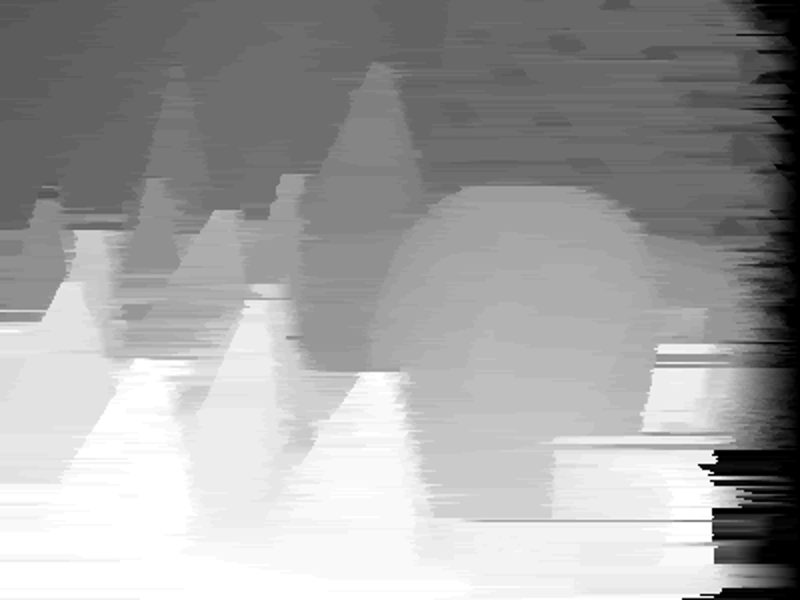

In [14]:
Image.fromarray(img_shift2[:,:,0].astype(np.uint8)).resize((800,600), Image.BICUBIC)

## Vertical shift (normed at 255)

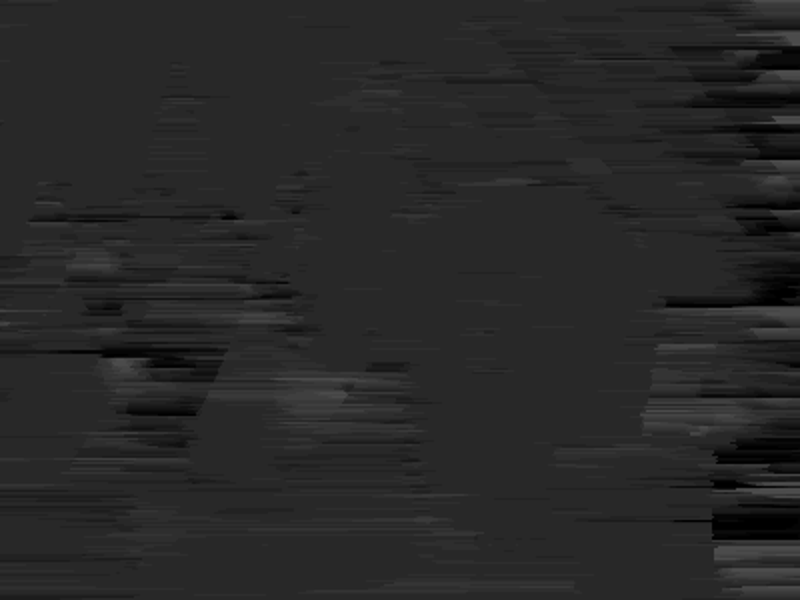

In [15]:
Image.fromarray(img_shift2[:,:,1].astype(np.uint8)).resize((800,600), Image.BICUBIC)

## Color shift image (normed at 255)

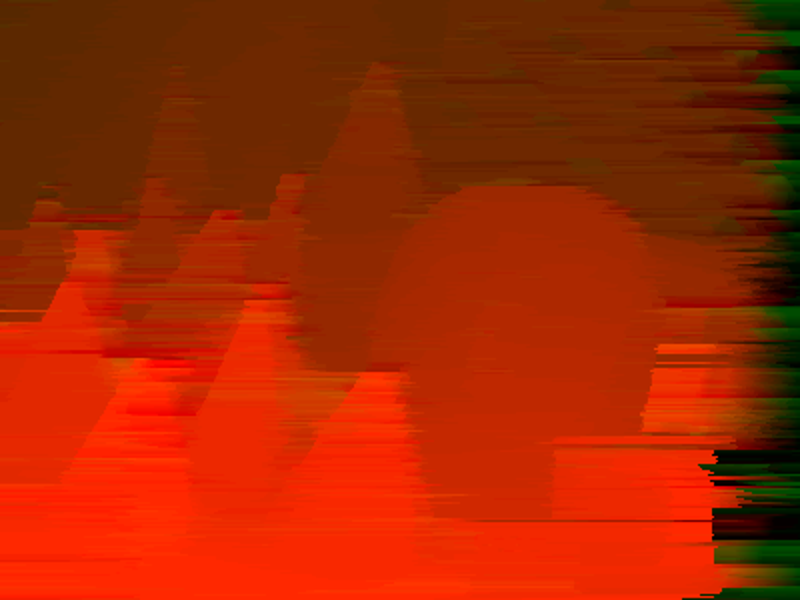

In [16]:
Image.fromarray(img_shift2.astype(np.uint8)).resize((800,600), Image.BICUBIC)

## Norm maps (normed at 255)

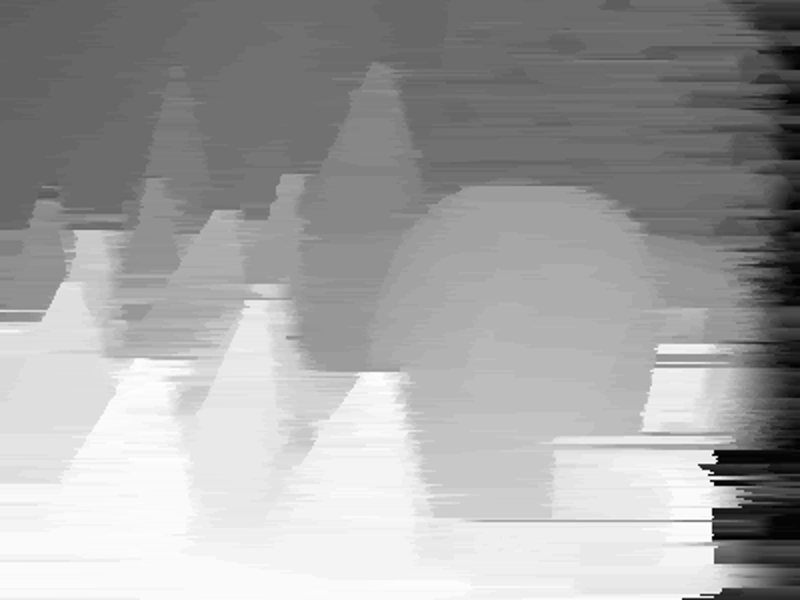

In [17]:
Image.fromarray(img_shift3.astype(np.uint8)).resize((800,600), Image.BICUBIC)

## Original image

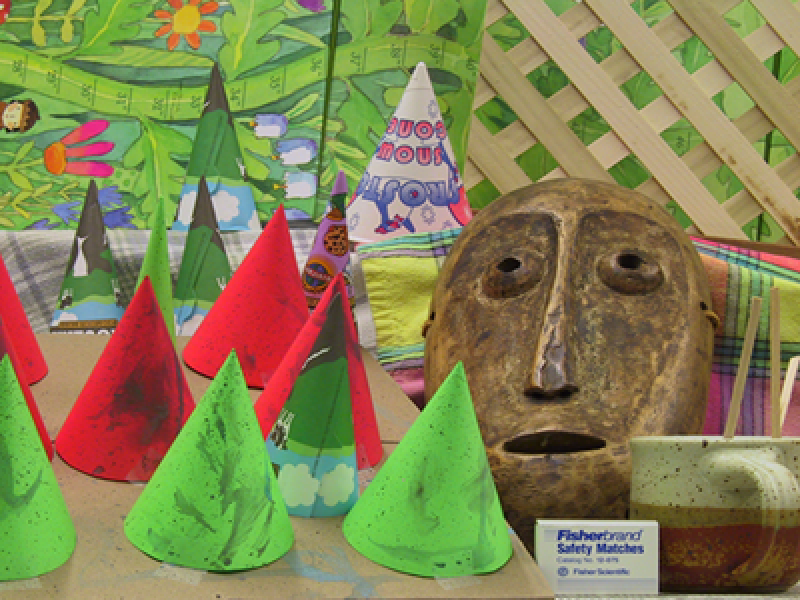

In [18]:
Image.fromarray(img_l.astype(np.uint8)).resize((800,600))

# lab2 start

https://staff.fnwi.uva.nl/l.dorst/hz/chap11_13.pdf